# Engine Fault Detection

> These examples are originally from the [AI Explainability 360 Toolkit for Time-Series and Industrial Use Cases](https://ai-library-examples.github.io/aix4industries/books/intro.html#) book.


Diagnostics is essential for assets and equiment in industrial domain. Specifically, fault detection is required to avoid asset failures in the future. In this demo, we cover a use case on fault detection in an automotive subsystem using [FordA engine noise data](https://timeseriesclassification.com/description.php?Dataset=FordA).

The FordA dataset is used in IEEE World Congress on Computational Intelligence (WCCI) competition in 2008. Each case/instance has 500 measurements of engine noise and the target is to diagnose whether a certain symptom (defect) exists or not in the automotive subsystem. Train and test data sets were collected in typical operating conditions, with minimal noise contamination. A classification model can be trained to detect fault for each test instance.

For this demo, we use the transformer model trained in [Keras time series examples](https://keras.io/examples/timeseries/timeseries_transformer_classification/). The model can be downloaded from [Huggingface Hub](https://huggingface.co/keras-io/timeseries_transformer_classification). TrustyAI will use AIX360's [Time Series Saliency Explainer (TSSaliencyExplainer)](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tssaliency/tssaliency.py) implementation to explain how each time point or temporal segments influenced the Keras transformer model's prediction for a test instance. Further, we use [Time Series Local Interpretable Model-agnostic Explainer (TSLime)](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tslime/tslime.py) (also provided by AIX360) to explain how much (magnitude) each time point in the test instance influenced the Keras transformer model's prediction.


For more algorithmic details on TSSaliency and TSLime, you can refer to [Time Series Saliency Explanation](efd:references:tssaliency) and [Time Series Local Interpretable Model-Agnostic Explanation](efd:references:tslime) sections respectively.

#### Time Series Saliency Explanation

Time Series Saliency (TSSaliency) Explainer is a model agnostic saliency explainer for time series associate tasks. The saliency supports univariate and multivariate use cases. It explains temporal importance of different variates on the model prediction. TSSaliency incorporates an integrated gradient method for saliency estimation and, therefore, provides reasonable values for functions that are continuous, and differentiable almost everywhere. It may be ill-suited to certain types of ensemble models such as Random Forests. The saliency measure involves the notion of a base value. For example, the base value can be the constant signal with average value. The saliency measure is computed by integrating the model sensitivity over a trajectory from the base value to the time series signal. The TSSaliency explainer provides variate wise contributions to model prediction at a temporal resolution.

#### Time Series Local Interpretable Model-Agnostic Explanation

Advanced time series models are complex and often hard to interpret. Time Series Local Interpretable Model-agnostic Explainer (TSLime) is a model-agnostic local time series explainer. It explains a time series model behavior using an approximate linear model as surrogate. TSLime approximates model response by evaluating the model over time series samples generated by applying time series perturbation techniques. The explanation produced by TSLime is the weights of the linear model over different time point observations. The relative signed value of the explanation is indicative of model sensitivity at temporal resolution. TSLime uses the recent time context length for the local surrogate model fitting. TSLime supports univariate and multi-variate use cases related to forecasting, time series classification, regression and anomaly detection.

### Imports

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
# to suppress unrelated tensorflow warnings while importing aix360.datasets
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import logging
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('../styles/material_rh.mplstyle')
import tensorflow as tf
from sklearn.metrics import accuracy_score
from huggingface_hub import from_pretrained_keras
from trustyai.utils.extras.timeseries import tsFrame
from trustyai.utils.extras.models import Tensor_Based_Classification_Model
from trustyai.explainers.extras.tssaliency import TSSaliencyExplainer
from huggingface_hub.utils import logging as h_logging
import utils.data as data

# huggingface hub warnings
h_logging.set_verbosity_error()

# tensorflow warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Load Dataset

Use the FordA dataset available [here](../data/FordA.zip)[^2]

[^2]: Alternatively, download the FordA dataset from [timeseriesclassification.com](https://timeseriesclassification.com/aeon-toolkit/FordA.zip) using the below code snippet.

In [2]:
input_length = 500
x_train, x_test, y_train, y_test = data.load_ford()

If the above dataset url does not work, follow the below steps. Otherwise, skip to [Plot the dataset](efd:references:plot_dataset).

- Install aeon library using `python -m pip install git+https://github.com/aeon-toolkit/aeon.git` to download the data using [aeon APIs](https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.datasets.load_classification.html#aeon.datasets.load_classification).
- Uncomment the code below and run it to download the data using `aeon` apis.


In [3]:
# from aeon.datasets import load_classification
# from sklearn.model_selection import train_test_split
# 
# X, y, meta = load_classification(name="ArrowHead")
# y = y.astype(int)
# y[y == -1] = 0
# x_train, x_test, y_train, y_test = train_test_split(
#             X, y, test_size=0.3, random_state=22
#         )

#### Plot the dataset.

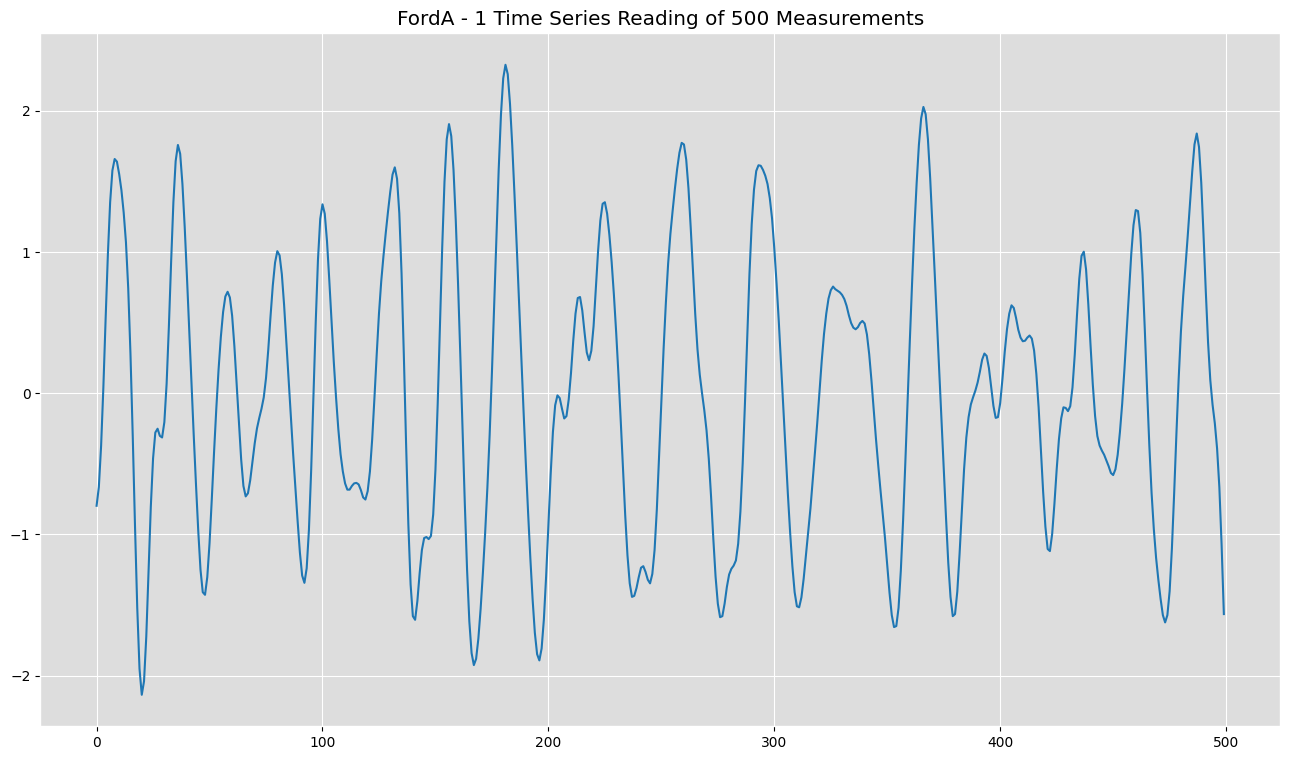

In [4]:
_ = pd.DataFrame(x_train[0]).plot(title="FordA - 1 Time Series Reading of 500 Measurements", legend=False)

### Download Pre-Trained Model

Download pre-trained [Keras trasnformer model](https://keras.io/examples/timeseries/timeseries_transformer_classification/) from [HuggingFace Hub](https://huggingface.co/keras-io/timeseries_transformer_classification).

In [5]:
model = from_pretrained_keras("keras-io/timeseries_transformer_classification")
model.summary()

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 1)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 500, 1)               2         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 500, 1)               7169      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

Test model accuracy.

In [6]:
class_pos = 0 # to select class probability for explanation
binary_model = Tensor_Based_Classification_Model(model, 
                                                 class_pos=class_pos, 
                                                 input_length=input_length, 
                                                 n_features=1)

test_sample_size = 10
y_pred = binary_model.predict(x_test[0:test_sample_size,...], verbose=0)

print("model accuracy for {} samples: {}.".format(test_sample_size, accuracy_score(y_test[:test_sample_size], y_pred.astype(int))))

model accuracy for 10 samples: 0.9.


### Initialize TSSaliencyExplainer
[TSSaliencyExplainer](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tssaliency/tssaliency.py) uses integrated gradients over the input timeseries to compute saliency metric. If user brings their own gradient computation function, it can be used using parameter `gradient_function`. By default, `aix360.algorithms.tssaliency.gradient.mc_gradient_compute` is used. Increasing `n_samples` and `gradient_samples` increases quality of the explanation.

In [7]:
tssaliency_explainer = TSSaliencyExplainer(model= functools.partial(binary_model.predict_proba, verbose = 0),
                        input_length= x_test.shape[1],
                        feature_names=['x'],
                        n_samples=5,
                        gradient_samples=10,
                               )

### Compute TSSaliency Explanation

Compute saliency metric for a given input timeseries. Base value is required for explanation computation and can be provided during initialization of the explainer or during explanation computation. Default is to compute mean of the signal.

In [8]:
indx = 3
instance = x_test[indx, ...]
base_value = np.mean(instance, axis=0) # base value 

ts_instance = tsFrame(instance) # tsFrame instance
ts_instance.index = pd.to_numeric(ts_instance.index)
tssaliency_explanation = tssaliency_explainer.explain(ts_instance, base_value=base_value)

By Proposition 1 in "section 3 Mukund Sundararajan et al. Axiomatic Attribution for Deep Networks", sum of saliency scores (Integrated Gradient) and model prediction delta (`f(instance) - f(base)`) between the input instance and the base value should be zero. As the value is closer to zero, quality of explanation is high.

In [9]:
instance_prediction = tssaliency_explanation.explanation["instance_prediction"]
base_value_prediction = tssaliency_explanation.explanation["base_value_prediction"]

pred_delta = instance_prediction - base_value_prediction
saliency_sum = np.sum(tssaliency_explanation.explanation['saliency'])

print("Sum of Saliency scores (Integrated Gradient): {}".format(saliency_sum))
print("f(instance) - f(base): {}".format(pred_delta))
print("|f(instance) - f(base) - sum IG|: {}".format(np.abs(pred_delta - saliency_sum)))

Sum of Saliency scores (Integrated Gradient): -0.5075698793114195
f(instance) - f(base): [-0.48889413]
|f(instance) - f(base) - sum IG|: [0.01867577]


### Plot TSSaliency Explanation

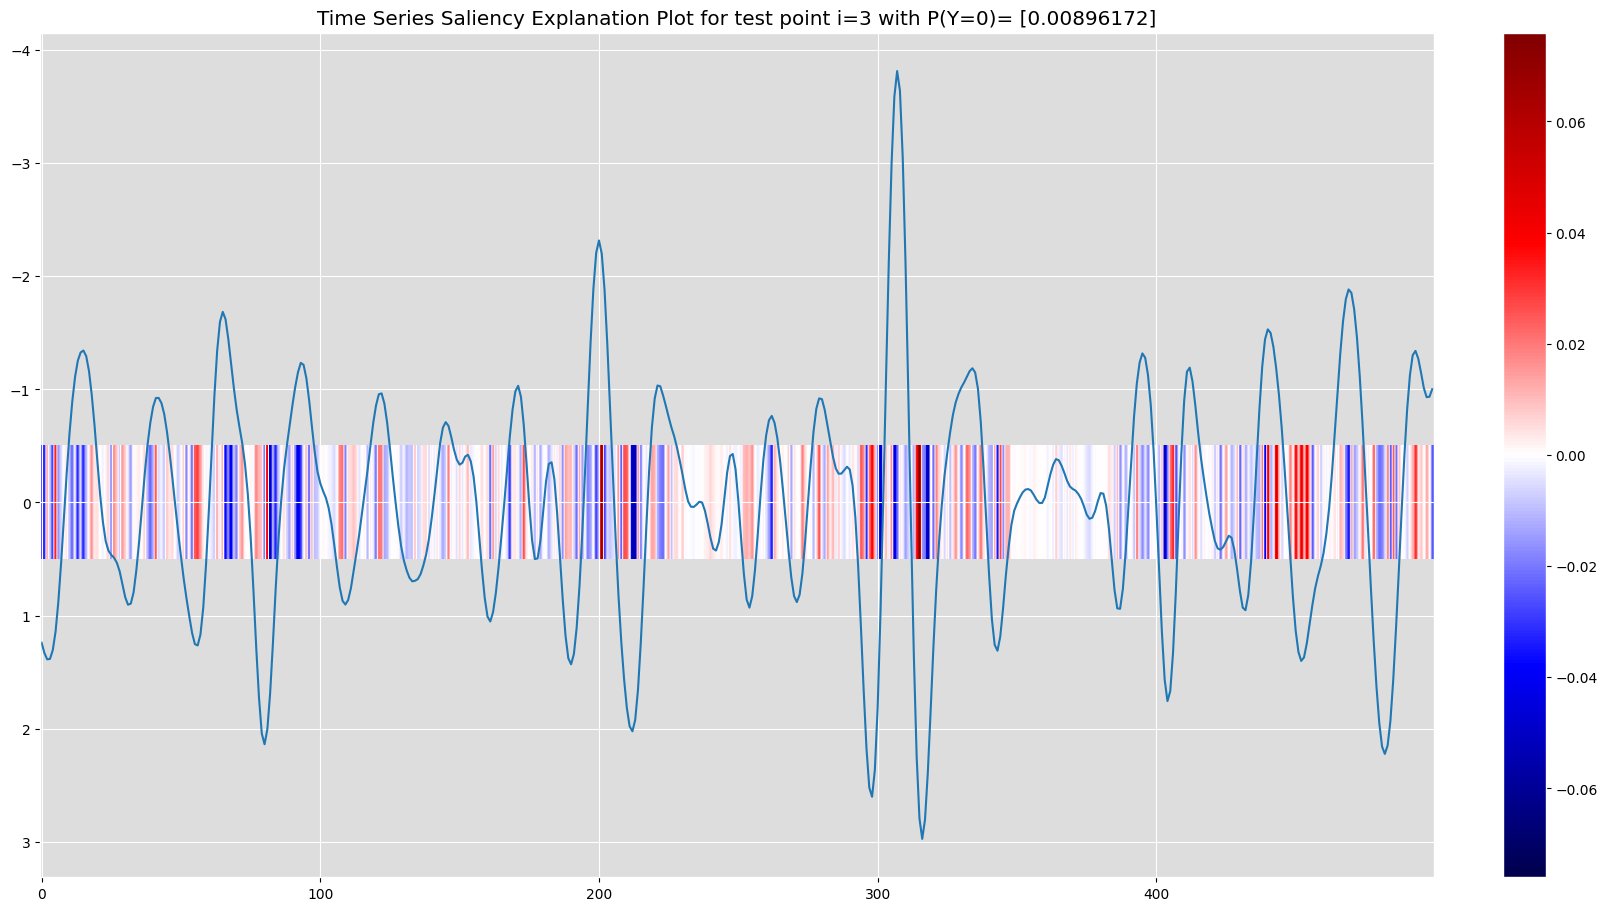

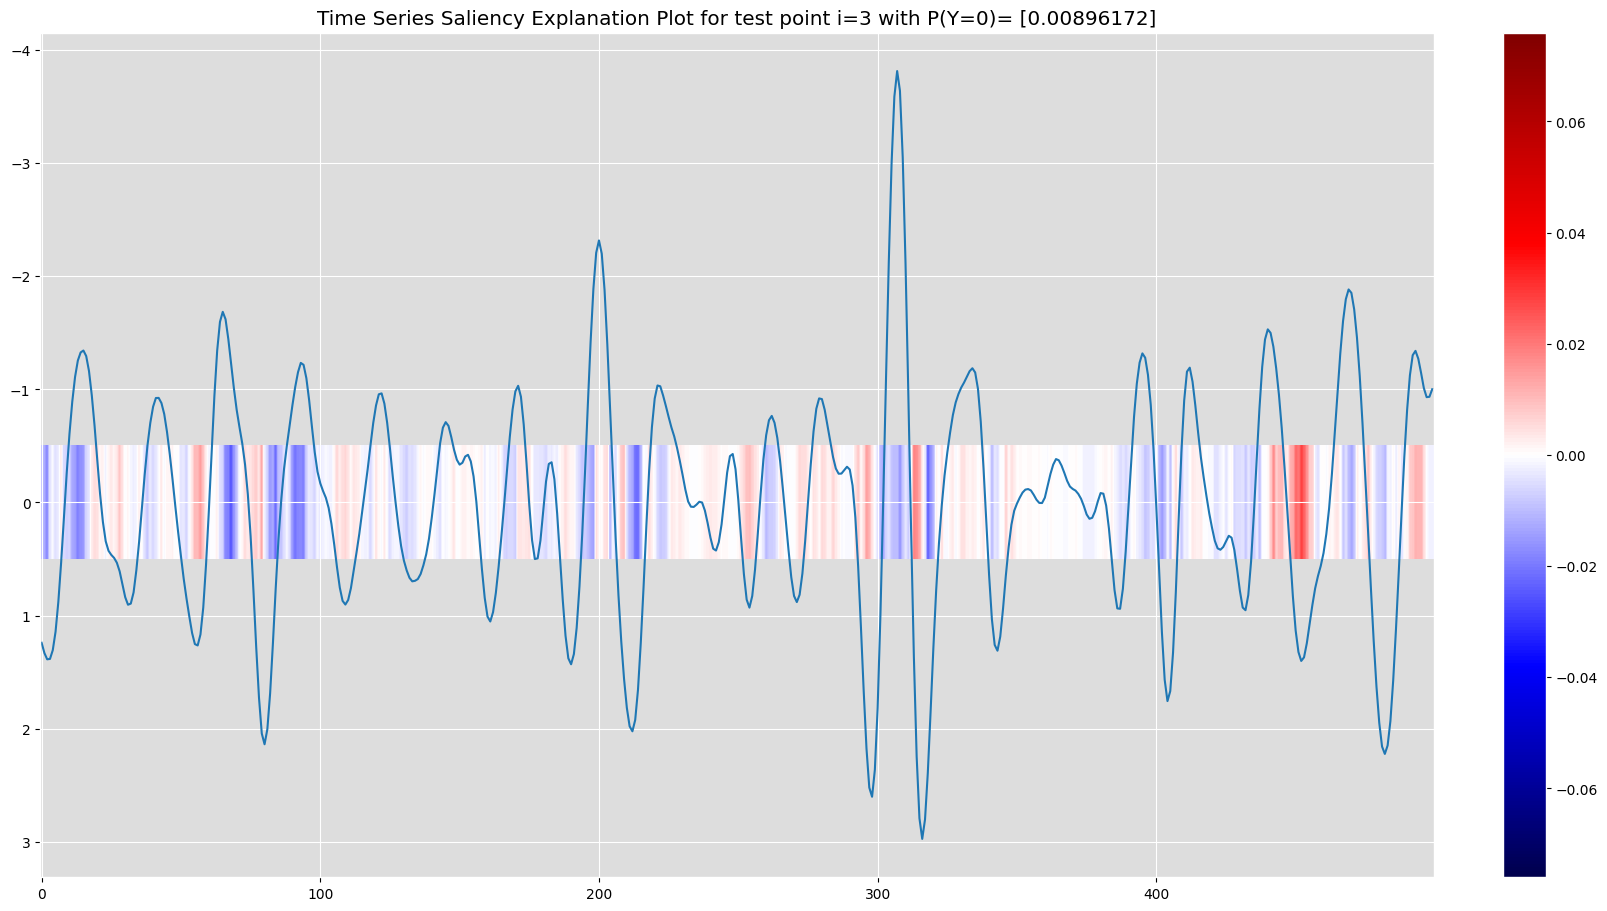

In [10]:
# plot tssaliency explanation for the test point
tssaliency_explanation.plot(index=indx, cpos=class_pos)

# plot smoothened tssaliency explanation for the test point
tssaliency_explanation.plot(index=indx, cpos=class_pos, window=5)

### Initialize TSLimeExplainer

[`TSLimeExplainer`](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tslime/tslime.py) requires a model function which is to be explained, and input (history) length used for the input model. The explanation is for selected latest window of length `relevant_history`. If `input_length=20` and `relevant_history=10`, explanation is computed for last 10 time points. The default linear model used for explanation is sklearn's LinearRegression. If a different linear interpretable model is to be used, the model can be wrapped with `aix360.algorithms.tslime.surrogate.LinearSurrogateModel` and provided as param `local_interpretable_model`. 

The explainer uses [TSPerturber](https://github.com/Trusted-AI/AIX360/blob/ef086583a1722b9a8714abc1ac6e8eeb9e3e3a2e/aix360/algorithms/tsutils/tsperturbers/tsperturber.py#L52) for generating perturbed/simulated time series data to train the linear interpretable model. Available perturbers are ["block-bootstrap"](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tsutils/tsperturbers/block_bootstrap_perturber.py)(default), ["frequency"](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tsutils/tsperturbers/frequency_perturber.py), ["moving_average"](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tsutils/tsperturbers/moving_average_perturber.py), and ["shift"](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tsutils/tsperturbers/ts_shift_perturber.py). 

In [11]:
from trustyai.explainers.extras.tslime import TSLimeExplainer
from trustyai.utils.extras.timeseries import BlockBootstrapPerturber

relevant_history = 100
tslime_explainer = TSLimeExplainer(
    model= functools.partial(binary_model.predict_proba, verbose = 0),
    input_length= x_test.shape[1],
    relevant_history=relevant_history,
    perturbers=[
        BlockBootstrapPerturber(window_length=min(10, input_length-1), block_length=20, block_swap=2),
    ],
    n_perturbations=10,
    random_seed=22,
)

### Compute TSLime Explanation

Compute lime weights for previously used test instance. Explanation object `explanation` contains the history weights computed for selected time window (relevant history) and surrogate prediction for this selected time window.

In [12]:
tslime_explanation = tslime_explainer.explain(ts_instance)

### Plot TSLime Explanation

The TSLime explanation plot shows the normalized weights for each time point in relevant(selected) history window. Weights are normalized/scaled using mean absolute over all the weights.

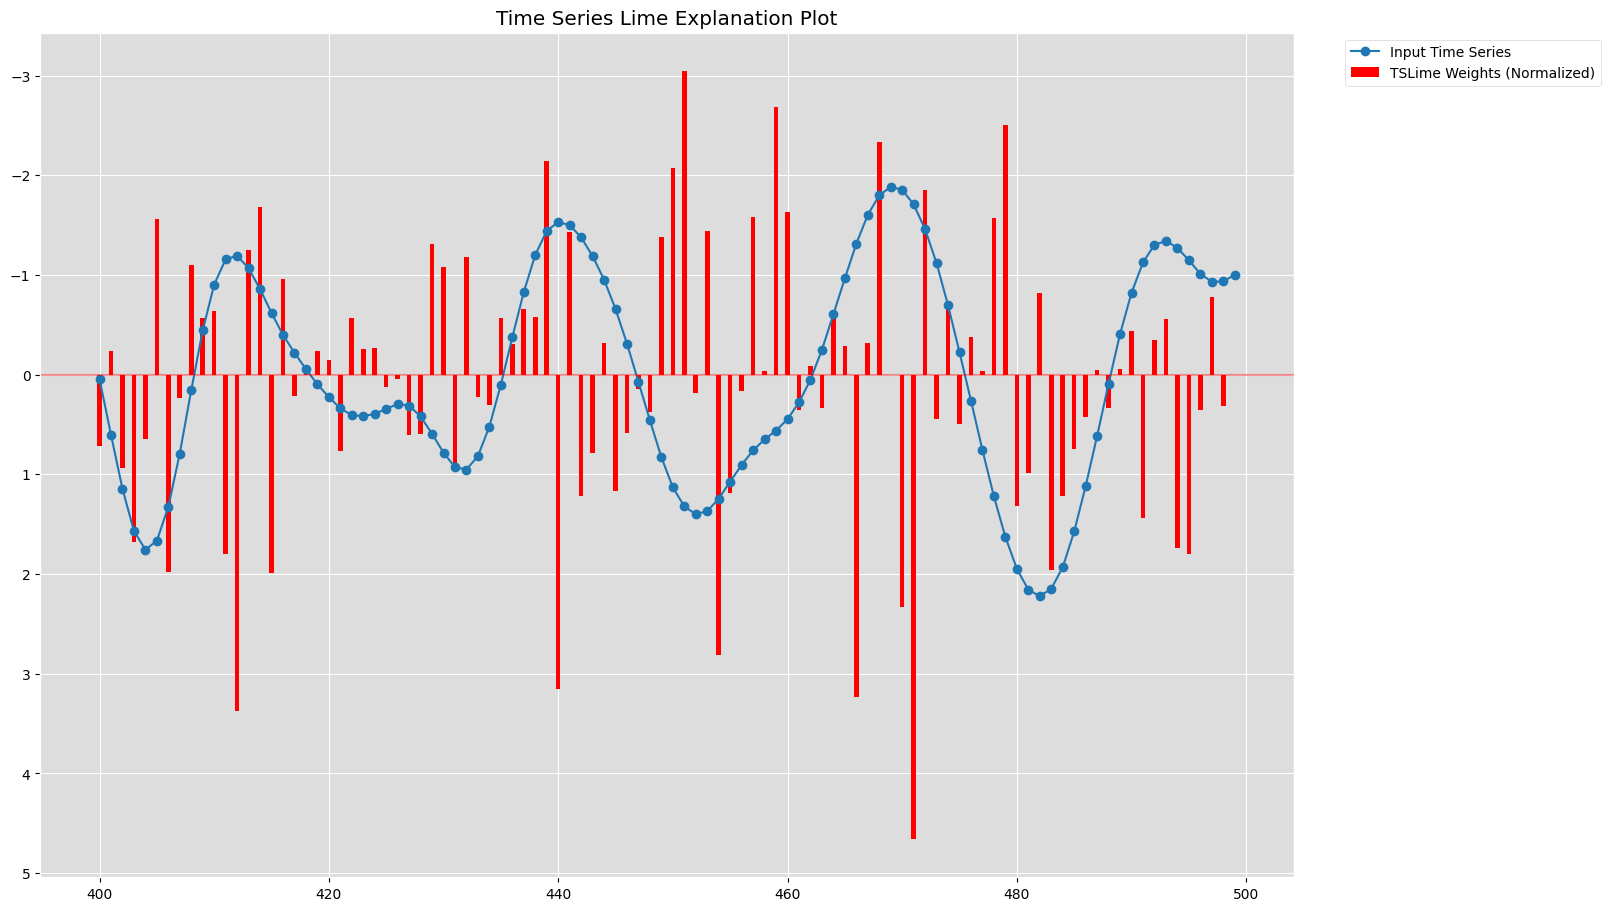

In [13]:
tslime_explanation.plot()